In [1]:
%load_ext autoreload
%autoreload 1
import os
import sys
sys.path.append("../..")

import numpy as np
import torch
from torch.utils.data import DataLoader, TensorDataset
import torch.nn as nn
from tqdm.auto import tqdm

from ntupleReaders.clue_ntuple_reader import ClueNtupleReader
from ml.plot_utils import plotLossPerEpoch

In [2]:
reader_sim = ClueNtupleReader("v40", "cmssw", "sim_proton_v46_patchMIP")
reader_data = ClueNtupleReader(reader_sim.version, reader_sim.clueParams, "data")
full_dataset = TensorDataset(*torch.load(os.path.join(reader_sim.pathToFolder, "tracksterProperties.pt")))

In [3]:
full_dataset.tensors[2]

tensor([100., 100., 100.,  ...,  80.,  80.,  80.])

In [4]:
totalev = len(full_dataset)
ntrain = int(0.8*totalev)
ntest = totalev - ntrain

ntrainbatch = 200
ntestbatch = 100
train_dataset, test_dataset = torch.utils.data.random_split(full_dataset, [ntrain, ntest])
trainloader = DataLoader(train_dataset, batch_size=ntrainbatch, shuffle=True)
testloader = DataLoader(test_dataset, batch_size=ntestbatch, shuffle=True)

In [20]:
from torch.utils.tensorboard import SummaryWriter
from datetime import datetime
current_time = datetime.now().strftime("%b%d_%H-%M-%S")
#writer = SummaryWriter(log_dir=os.path.join("Plotting/", "pytorch_runs", "tracksterProperties", current_time))
writer = SummaryWriter()

In [6]:
hidden_size = 10
class Model(torch.nn.Module):
    def __init__(self) -> None:
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(4, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, 1)
        )
    def forward(self, x):
        return self.net(x)

In [9]:
train_dataset[0][0]

tensor([89.3036, 10.0000,  4.0000, 13.0000])

In [22]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = Model().to(device)
writer.add_graph(model, train_dataset[0][0])

In [17]:
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-2)

mse = torch.nn.MSELoss()
def lossComputation(result:torch.Tensor, trueBeamEnergy:torch.Tensor):
    # return mse(result, data[1])  # Loss is MSE of E_estimate - E_beam
    result = torch.squeeze(result)
    return mse(result/trueBeamEnergy, torch.ones_like(result))  # Loss is MSE of E_estimate / E_beam wrt to 1


lossc,lossr = [],[]
epochs = []
opt = torch.optim.Adam(model.parameters(), lr=0.001)
#opt = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-3)
#opt = torch.optim.SGD(model.parameters(), lr=1e-1)#, nesterov=True)

def train(epoch):
    model.train()
    #torch.cuda.empty_cache()
    #scheduler.step()
    loss = []
    for data in tqdm(trainloader):
            data[0] = data[0].to(device)
            data[1] = data[1].to(device)
            optimizer.zero_grad()
            result = model(data[0])

            lossc = lossComputation(result, data[1])

            loss.append(lossc.item()) 
            lossc.backward()
            optimizer.step()
            #scheduler.batch_step()
    print( 'batches for train:',len(loss)) 
    print('train loss:',np.mean(np.array(loss)))
    return np.mean(np.array(loss))



def evaluate(epoch):
    model.eval()
    #torch.cuda.empty_cache()
    #scheduler.step()
    loss = []
    pred = []
    true = []
    calc = []
    for data in tqdm(testloader):
            data[0] = data[0].to(device)
            data[1] = data[1].to(device)
            #print(data[0])
            optimizer.zero_grad()
            result = model(data[0])
            #print(result)
            lossc = lossComputation(result, data[1])
            loss.append(lossc.item()) 
            lossc.backward()
            optimizer.step()
            #scheduler.batch_step()
            for i in result:
                pred.append(i.detach().cpu())
                #predc.append(i.detach().cpu().argmax())
            for i in data[1].detach():
                true.append(i.detach().cpu())
            for i in data[0].detach():
                calc.append(torch.sum(i.detach().cpu()))    
    
    if False:
        from matplotlib.pyplot import figure
        figure(figsize=(15, 15), dpi=40)
        #plt.rcParams['axes.labelsize'] = 36
        #plt.rcParams['axes.titlesize'] = 36
        #plt.hist2d(truea,preda,bins=200)
        #plt.scatter(truea,preda,alpha=0.4)
        #plt.scatter(truea,preda,alpha=0.4)
        
        plt.hist(np.array(pred)/np.array(true),bins=100,range=[0.75,1.25],label='pred')
        plt.hist(np.array(calc)/np.array(true),bins=100,range=[0.75,1.25],label='calc')
        #plt.plot([0,2], [0,2], 'k-')
        plt.xticks(fontsize=16)
        plt.yticks(fontsize=16)
        #plt.xlim([-2, 18])
        #plt.ylim([-2, 20])
        plt.axvline(x=1.0,c='r')
        #plt.axhline(y=1.0,c='r')
        plt.legend()
        plt.show()
    
    
    print( 'batches for test:',len(loss)) 
    print('test loss:',np.mean(np.array(loss)))
    #print("calib weights:",model.weights)
    return np.mean(np.array(loss))

epoch: 0


  0%|          | 0/1439 [00:00<?, ?it/s]

batches for train: 1439
train loss: 0.004141519099007645


  0%|          | 0/720 [00:00<?, ?it/s]

batches for test: 720
test loss: 0.00402172719235144
new best test loss: 0.00402172719235144
epoch: 1


  0%|          | 0/1439 [00:00<?, ?it/s]

batches for train: 1439
train loss: 0.004124453928264322


  0%|          | 0/720 [00:00<?, ?it/s]

batches for test: 720
test loss: 0.004008536432391136
new best test loss: 0.004008536432391136
epoch: 2


  0%|          | 0/1439 [00:00<?, ?it/s]

batches for train: 1439
train loss: 0.004123921092302565


  0%|          | 0/720 [00:00<?, ?it/s]

batches for test: 720
test loss: 0.004024423635645588
epoch: 3


  0%|          | 0/1439 [00:00<?, ?it/s]

batches for train: 1439
train loss: 0.004125180577574838


  0%|          | 0/720 [00:00<?, ?it/s]

batches for test: 720
test loss: 0.004027223796583712
epoch: 4


  0%|          | 0/1439 [00:00<?, ?it/s]

batches for train: 1439
train loss: 0.00412210354118241


  0%|          | 0/720 [00:00<?, ?it/s]

batches for test: 720
test loss: 0.004035637119846392
epoch: 5


  0%|          | 0/1439 [00:00<?, ?it/s]

batches for train: 1439
train loss: 0.004119545140388131


  0%|          | 0/720 [00:00<?, ?it/s]

batches for test: 720
test loss: 0.004034292572517491
epoch: 6


  0%|          | 0/1439 [00:00<?, ?it/s]

batches for train: 1439
train loss: 0.0041209951322962604


  0%|          | 0/720 [00:00<?, ?it/s]

batches for test: 720
test loss: 0.004021669144438218
epoch: 7


  0%|          | 0/1439 [00:00<?, ?it/s]

batches for train: 1439
train loss: 0.004118366964382092


  0%|          | 0/720 [00:00<?, ?it/s]

batches for test: 720
test loss: 0.004029481394617404
epoch: 8


  0%|          | 0/1439 [00:00<?, ?it/s]

batches for train: 1439
train loss: 0.004125528582491504


  0%|          | 0/720 [00:00<?, ?it/s]

batches for test: 720
test loss: 0.00401136575237615
epoch: 9


  0%|          | 0/1439 [00:00<?, ?it/s]

batches for train: 1439
train loss: 0.004124977601312821


  0%|          | 0/720 [00:00<?, ?it/s]

batches for test: 720
test loss: 0.004006608561353965
new best test loss: 0.004006608561353965
epoch: 10


  0%|          | 0/1439 [00:00<?, ?it/s]

batches for train: 1439
train loss: 0.004123454575738828


  0%|          | 0/720 [00:00<?, ?it/s]

batches for test: 720
test loss: 0.004037537043041084
epoch: 11


  0%|          | 0/1439 [00:00<?, ?it/s]

batches for train: 1439
train loss: 0.00412326254660252


  0%|          | 0/720 [00:00<?, ?it/s]

batches for test: 720
test loss: 0.004024094958650595
epoch: 12


  0%|          | 0/1439 [00:00<?, ?it/s]

batches for train: 1439
train loss: 0.004118992776342663


  0%|          | 0/720 [00:00<?, ?it/s]

batches for test: 720
test loss: 0.004028541413249008
epoch: 13


  0%|          | 0/1439 [00:00<?, ?it/s]

batches for train: 1439
train loss: 0.004109816787959561


  0%|          | 0/720 [00:00<?, ?it/s]

batches for test: 720
test loss: 0.0040259736494691525
epoch: 14


  0%|          | 0/1439 [00:00<?, ?it/s]

batches for train: 1439
train loss: 0.004119516286377351


  0%|          | 0/720 [00:00<?, ?it/s]

batches for test: 720
test loss: 0.004020111182601088
epoch: 15


  0%|          | 0/1439 [00:00<?, ?it/s]

batches for train: 1439
train loss: 0.0041240007359964245


  0%|          | 0/720 [00:00<?, ?it/s]

batches for test: 720
test loss: 0.004010963082045136
epoch: 16


  0%|          | 0/1439 [00:00<?, ?it/s]

batches for train: 1439
train loss: 0.004109844065226338


  0%|          | 0/720 [00:00<?, ?it/s]

batches for test: 720
test loss: 0.004026056072325446
epoch: 17


  0%|          | 0/1439 [00:00<?, ?it/s]

batches for train: 1439
train loss: 0.004123121158818859


  0%|          | 0/720 [00:00<?, ?it/s]

batches for test: 720
test loss: 0.0040305074616400005
epoch: 18


  0%|          | 0/1439 [00:00<?, ?it/s]

batches for train: 1439
train loss: 0.004120980774136901


  0%|          | 0/720 [00:00<?, ?it/s]

batches for test: 720
test loss: 0.004023644088657521
epoch: 19


  0%|          | 0/1439 [00:00<?, ?it/s]

batches for train: 1439
train loss: 0.004114483413440217


  0%|          | 0/720 [00:00<?, ?it/s]

batches for test: 720
test loss: 0.004033185327716638
epoch: 20


  0%|          | 0/1439 [00:00<?, ?it/s]

batches for train: 1439
train loss: 0.004112537020653657


  0%|          | 0/720 [00:00<?, ?it/s]

batches for test: 720
test loss: 0.004022166794068956
epoch: 21


  0%|          | 0/1439 [00:00<?, ?it/s]

batches for train: 1439
train loss: 0.004114785418205631


  0%|          | 0/720 [00:00<?, ?it/s]

batches for test: 720
test loss: 0.004011170802146404
epoch: 22


  0%|          | 0/1439 [00:00<?, ?it/s]

batches for train: 1439
train loss: 0.0041204778361619634


  0%|          | 0/720 [00:00<?, ?it/s]

batches for test: 720
test loss: 0.004012315738913862
epoch: 23


  0%|          | 0/1439 [00:00<?, ?it/s]

batches for train: 1439
train loss: 0.004114949498522983


  0%|          | 0/720 [00:00<?, ?it/s]

batches for test: 720
test loss: 0.004025358476873306
epoch: 24


  0%|          | 0/1439 [00:00<?, ?it/s]

batches for train: 1439
train loss: 0.0041220201544811185


  0%|          | 0/720 [00:00<?, ?it/s]

batches for test: 720
test loss: 0.003985870145940377
new best test loss: 0.003985870145940377
epoch: 25


  0%|          | 0/1439 [00:00<?, ?it/s]

batches for train: 1439
train loss: 0.004123433582108375


  0%|          | 0/720 [00:00<?, ?it/s]

batches for test: 720
test loss: 0.004024620828123362
epoch: 26


  0%|          | 0/1439 [00:00<?, ?it/s]

batches for train: 1439
train loss: 0.0041097907010981035


  0%|          | 0/720 [00:00<?, ?it/s]

batches for test: 720
test loss: 0.004012494320987672
epoch: 27


  0%|          | 0/1439 [00:00<?, ?it/s]

batches for train: 1439
train loss: 0.004115308885160986


  0%|          | 0/720 [00:00<?, ?it/s]

batches for test: 720
test loss: 0.0040266535660420134
epoch: 28


  0%|          | 0/1439 [00:00<?, ?it/s]

batches for train: 1439
train loss: 0.004118064996345348


  0%|          | 0/720 [00:00<?, ?it/s]

batches for test: 720
test loss: 0.00401365026708744
epoch: 29


  0%|          | 0/1439 [00:00<?, ?it/s]

batches for train: 1439
train loss: 0.004121461769239427


  0%|          | 0/720 [00:00<?, ?it/s]

batches for test: 720
test loss: 0.004017694049050786


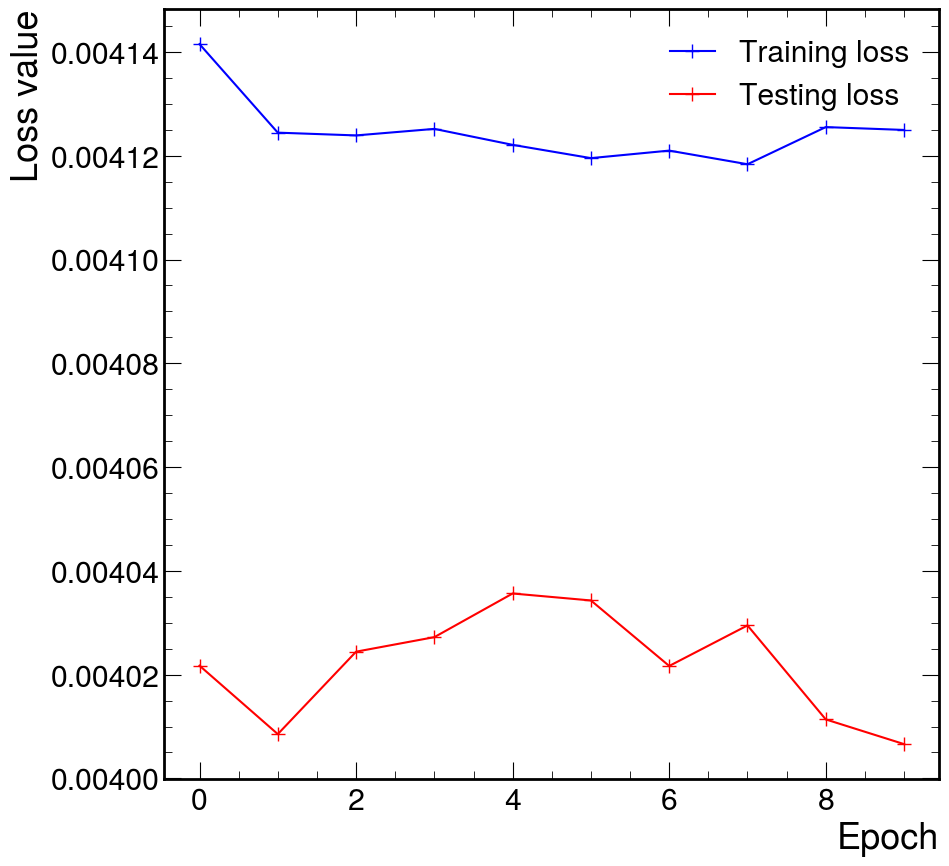

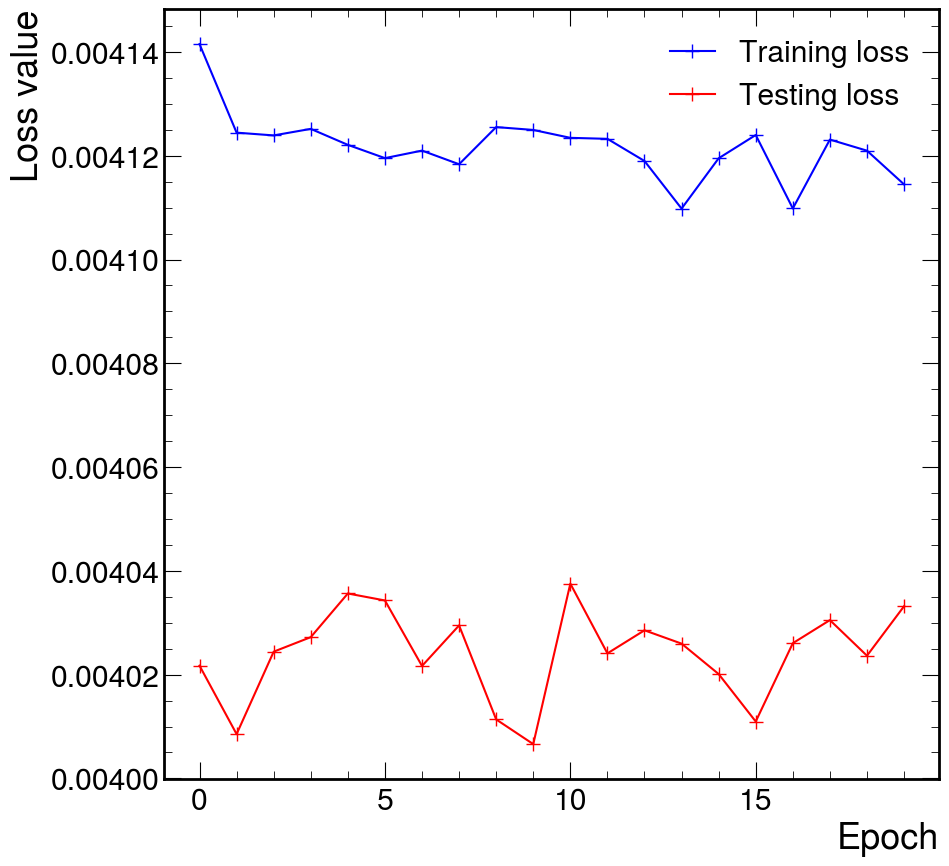

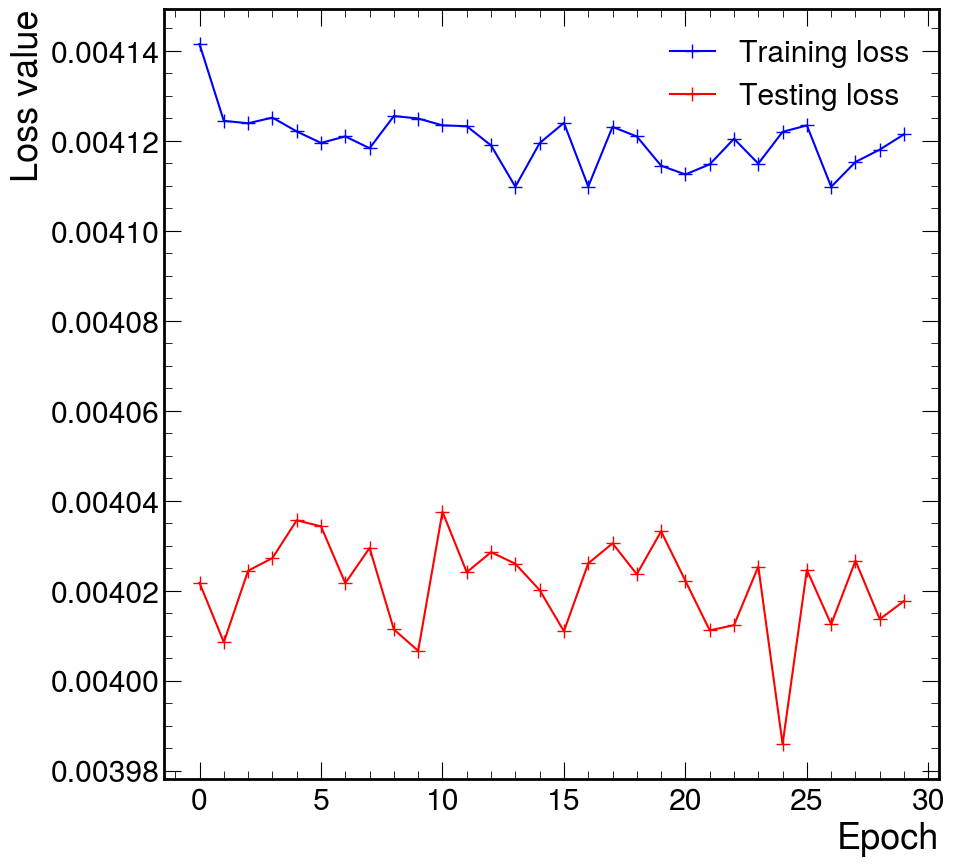

In [18]:
nepoch=30
#os.makedirs(checkpoint_dir, exist_ok=True)
best_loss = 99999999
losst = []
lossv = []
epochs = []
for epoch in range(nepoch):
    print ('epoch:',epoch)
    losst.append(train(epoch))
    loss_epoch = evaluate(epoch)
    lossv.append(loss_epoch)
    epochs.append(epoch)
    #checkpoint = {
    #'epoch': epoch + 1,
    #'state_dict': model.state_dict(),
    #'optimizer': optimizer.state_dict()
    #}
    
    #checkpoint_file = 'model_epoch_%i.pth.tar' % ( epoch )
    #torch.save(checkpoint,
    #               os.path.join(checkpoint_dir,checkpoint_file ))
    if loss_epoch < best_loss:
        best_loss = loss_epoch
        print('new best test loss:',best_loss)
        #torch.save(checkpoint,
        #           os.path.join(checkpoint_dir,'model_checkpoint_best.pth.tar' ))
    if ((epoch+1)%10 == 0):
        plotLossPerEpoch(epochs, losst, lossv)

In [10]:
%aimport ml.regression.tracksterProperties
from ml.regression.tracksterProperties import fillHistogramsFromTensors
import hist

In [11]:
h = fillHistogramsFromTensors(model, full_dataset)

In [12]:
%aimport ml.energy_resolution_tools
from energy_resolution.sigma_over_e import SigmaOverEComputations

/grid_mnt/vol_home/llr/cms/cuisset/mambaforge/envs/clustering-analysis-torch/lib/python3.10/site-packages/zfit/__init__.py:63: UserWarning: TensorFlow warnings are by default suppressed by zfit. In order to show them, set the environment variable ZFIT_DISABLE_TF_WARNINGS=0. In order to suppress the TensorFlow warnings AND this warning, set ZFIT_DISABLE_TF_WARNINGS=1.
  warnings.warn(
/grid_mnt/vol_home/llr/cms/cuisset/mambaforge/envs/clustering-analysis-torch/lib/python3.10/site-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [13]:
comp = SigmaOverEComputations()
comp.compute(h)

Fitting:   0%|          | 0/10 [00:00<?, ?it/s]

Iterative fitting - 20 GeV:   0%|          | 0/5 [00:00<?, ?it/s]

Iterative fitting - 30 GeV:   0%|          | 0/5 [00:00<?, ?it/s]

Iterative fitting - 49 GeV:   0%|          | 0/5 [00:00<?, ?it/s]

Iterative fitting - 79 GeV:   0%|          | 0/5 [00:00<?, ?it/s]

Iterative fitting - 99 GeV:   0%|          | 0/5 [00:00<?, ?it/s]

Iterative fitting - 119 GeV:   0%|          | 0/5 [00:00<?, ?it/s]

Iterative fitting - 149 GeV:   0%|          | 0/5 [00:00<?, ?it/s]

Iterative fitting - 197 GeV:   0%|          | 0/5 [00:00<?, ?it/s]

Iterative fitting - 244 GeV:   0%|          | 0/5 [00:00<?, ?it/s]

Iterative fitting - 288 GeV:   0%|          | 0/5 [00:00<?, ?it/s]

{20: SigmaMuResult(mu=20.426542438372667+/-0.005401508110350024, sigma=0.6583344915441799+/-0.004720436705466089, fitResult=<zfit.minimizers.fitresult.FitResult object at 0x7f1024742620>),
 30: SigmaMuResult(mu=29.81155615319489+/-0.011235399848508564, sigma=1.210989328149473+/-0.009414047723432234, fitResult=<zfit.minimizers.fitresult.FitResult object at 0x7f101c6d6dd0>),
 50: SigmaMuResult(mu=49.49089502433111+/-0.01420875044908768, sigma=1.5805575486470387+/-0.011814422860109513, fitResult=<zfit.minimizers.fitresult.FitResult object at 0x7f10304b5570>),
 80: SigmaMuResult(mu=79.18295223568461+/-0.020128102447168703, sigma=2.0285275378613754+/-0.016661744639438907, fitResult=<zfit.minimizers.fitresult.FitResult object at 0x7f1024535ae0>),
 100: SigmaMuResult(mu=99.06150935212224+/-0.024595441014427236, sigma=2.2605483986355344+/-0.019830409750773586, fitResult=<zfit.minimizers.fitresult.FitResult object at 0x7f1014711180>),
 120: SigmaMuResult(mu=119.00096170063509+/-0.02654312455625

<Axes: xlabel='$S (\\sqrt{GeV} \\%)$', ylabel='C (%)'>

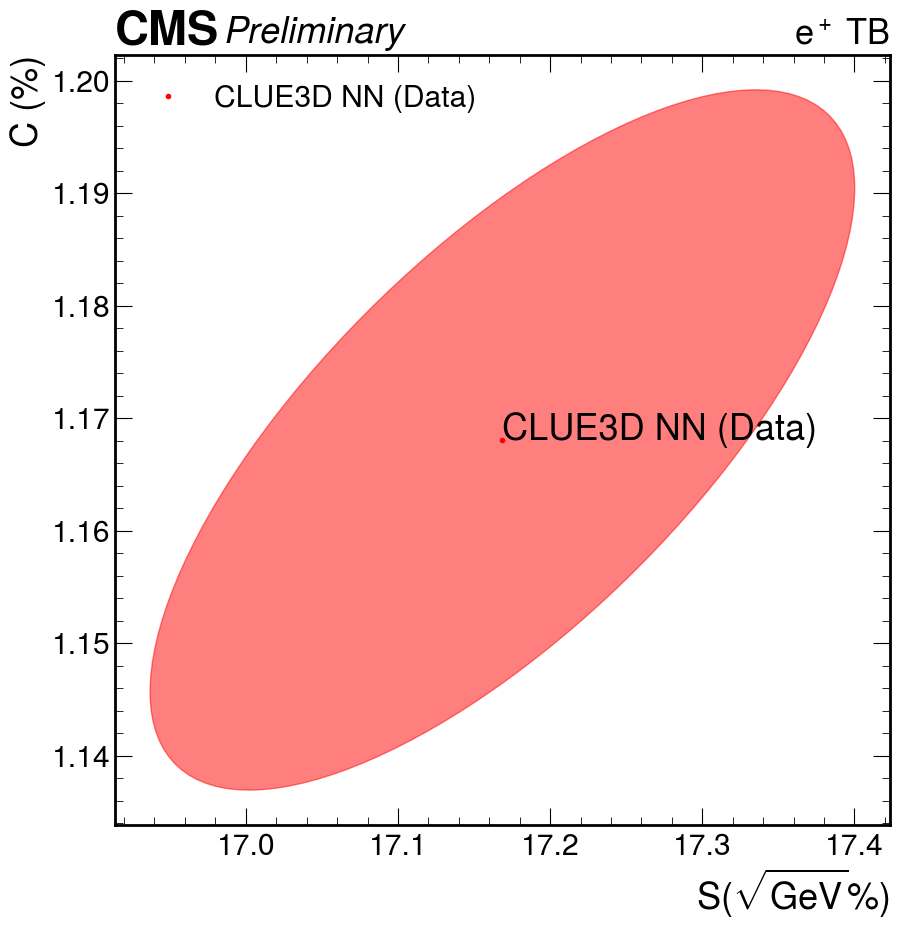

In [14]:
from energy_resolution.sigma_over_e import SigmaOverEPlotElement, plotSCAsEllipse, plotSigmaOverMean, sigmaOverE_fitFunction, fitSigmaOverE
import mplhep as hep
plotSCAsEllipse([
    #reader_sim.loadSigmaOverEResults("rechits")._replace(legend="$\\frac{dE}{dx}$ weights (Data)"),
    SigmaOverEPlotElement(legend="CLUE3D NN (Data)", fitResult=fitSigmaOverE(comp.results), color="red")
])
hep.cms.text("Preliminary")
hep.cms.lumitext("$e^+$ TB")